### Import Libraries

In [1]:
import numpy as np # working with array
import pandas as pd # importing data 
from operator import index #conversion of numericobj to interger obj
from pyexpat.errors import XML_ERROR_TEXT_DECL
#from turtle import home
from unicodedata import category #encoding categorial data
import matplotlib.pyplot as plt #plotting graphs
from scipy import rand #to find random value
import seaborn as sns #to create charts and graphs

from sklearn.metrics import mean_squared_error # to calculate mse

Seed = 42
np.random.seed(Seed) #seeding to grow random trees

### Load the datasets

##### <a name="data-desc"></a>Provided data description

- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

In [2]:
train = pd.read_csv('sales_train.csv')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')

In [3]:
train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


In [4]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


##### <a name="data-desc"></a>Merge categories_id in train set
- Merge categories_id in train set
- Drop string feature from dataset
- Change negative values in item_cnt_day feature

In [5]:
# merge categories_id in train set
train = train.merge(right=items, how='inner', on='item_id')

# drop string feature from dataset
train.drop(labels=['item_name'], axis = 1, inplace=True)

# change negative values in item_cnt_day feature
train['item_cnt_day'] = np.abs(train['item_cnt_day'])

grouped_train = train.groupby(by=['date_block_num', 'shop_id', 'item_category_id', 'item_id'], ).agg({'item_cnt_day':sum}).reset_index()


In [6]:
grouped_train.head()

,date_block_num,shop_id,item_category_id,item_id,item_cnt_day
0,0,0,2,5572,10.0
1,0,0,2,5573,1.0
2,0,0,2,5575,4.0
3,0,0,2,5576,5.0
4,0,0,2,5609,1.0


#### Shffle the dataframe first to random the rows
* split target from train 'item_cnt_day'
* drop item_cnt_day and date_block_num features

In [7]:
# Shffle the dataframe first to random the rows
grouped_train = grouped_train.sample(frac=1, random_state=Seed)

# split target from train 'item_cnt_day'
target  = grouped_train['item_cnt_day']

# drop item_cnt_day and date_block_num features
grouped_train.drop(labels=['item_cnt_day', 'date_block_num'], axis =1, inplace=True)


#### show the correlation between features

<AxesSubplot:>

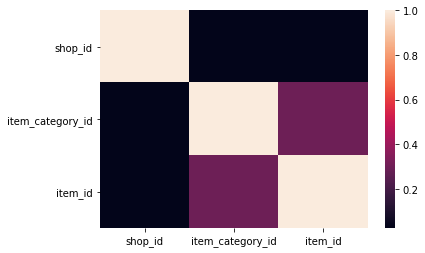

In [8]:
grouped_train.describe()

sns.heatmap(grouped_train.corr())


#### Split Train and valid data

In [9]:
# Split Train and valid data
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(grouped_train, target, test_size=10_000)

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1599124, 3), (10000, 3), (1599124,), (10000,))

#### Prepare test data

In [10]:
# Prepare test data
test = pd.read_csv('test.csv')

test = test.merge(right=items, how='inner', on='item_id')
x_test = test.drop(labels=['item_name', 'ID'], axis=1)

# change the order of features ['shop_id', 'item_id', 'item_category_id'] to ['shop_id', 'item_category_id', 'item_id']
x_test = x_test[['shop_id', 'item_category_id', 'item_id']]


In [11]:
test.head()

,ID,shop_id,item_id,item_name,item_category_id
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19
1,5100,4,5037,"NHL 15 [PS3, русские субтитры]",19
2,10200,6,5037,"NHL 15 [PS3, русские субтитры]",19
3,15300,3,5037,"NHL 15 [PS3, русские субтитры]",19
4,20400,2,5037,"NHL 15 [PS3, русские субтитры]",19


#### Scale the features

In [12]:
# Scale the data using StandardScaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
x_test = sc.transform(x_test)


#### Build the Models

##### 1 - RandomForest Algorithm

In [13]:
''' 1- Random Forest Model'''
from sklearn.ensemble import RandomForestRegressor
rnd_reg = RandomForestRegressor(n_estimators=150, max_depth=20, random_state=Seed, 
    n_jobs=-1, criterion='mse')

print('Training the data....')
rnd_reg.fit(x_train, y_train)

# Score the model
print('Model Accuracy...')
score = rnd_reg.score(x_valid, y_valid)
print(score)

# Model RMSE
print('Model RMSE...')
y_pred_valid_rnd = rnd_reg.predict(x_valid)
rmse_rnd = mean_squared_error(y_valid, y_pred_valid_rnd, squared=False)
print(rmse_rnd)

# predict the test set
print('Predict the test data...')
y_pred_rnd = rnd_reg.predict(x_test)
y_pred_rnd = np.round(y_pred_rnd).astype(np.int64)
print(y_pred_rnd)



Training the data....
Model Accuracy...
0.42920808764694485
Model RMSE...
5.133712843694866
Predict the test data...
[2 2 2 ... 1 1 1]


##### 2- XGBRegressor

In [14]:
conda install py-xgboost


Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [15]:
'''2- XGBoost'''

import xgboost as xg
xg_reg = xg.XGBRegressor(n_estimators =120, learning_rate = .01, random_state = Seed, n_jobs = -1,)


print('Training the data....')
xg_reg.fit(x_train, y_train)

# Score the model
print('Model Accuracy...')
score = xg_reg.score(x_valid, y_valid)
print(score)

# Model RMSE
print('Model RMSE...')
y_pred_valid_xgb = xg_reg.predict(x_valid)
rmse_xgb = mean_squared_error(y_valid, y_pred_valid_xgb, squared=False)
print(rmse_xgb)

# predict the test set
print('Predicting the test data...')
y_pred_xgb = xg_reg.predict(x_test)
y_pred_xgb = np.round(y_pred_xgb).astype(np.int64)
print(y_pred_xgb)

Training the data....
Model Accuracy...
0.6780222442647269
Model RMSE...
3.8557210068557577
Predicting the test data...
[2 2 2 ... 1 1 1]


#Thank You